In [2]:
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_datasets as tfds
import keras
from tensorflow.keras.layers import *

In [3]:
#loading datasets through tensorflow datasets
#(x_train,y_train),(x_val,y_val) = cifar10.load_data() <-- this is the same thing but with the keras dataset
#it's better to learn with tensorflow datasets because there are a lot more of them, so if you want to use datasets other than cifar or mnist they are pretty useful
train_dataset = tfds.load("cifar10", with_info=False,split=tfds.Split.TRAIN)
#IMPORTANT: tfds.load returns a dataset as a dictionary, so .map must be used to iterate through data so model read and fit data
train_dataset = train_dataset.map(lambda ele: tuple([ele['image'], ele['label']])).repeat().batch(16)

test_dataset = tfds.load("cifar10", with_info=False,split=tfds.Split.TEST)
test_dataset = test_dataset.map(lambda ele: tuple([ele['image'], ele['label']])).repeat().batch(16)

In [4]:
#we are going to be turning the dense block into a function so the model looks cleaner
#also because we use the same series of convolutions over and over
#you'll notice dense block is smaller and more modular than in the original paper. This is because cifar10 doesn't need as much processing 
def dense_block(inputs):
    x1 = Conv2D(filters=16,kernel_size=1,padding='same',activation='relu')(inputs)
    x1 = Conv2D(filters=32,kernel_size=3,padding='same',activation='relu')(x1)
    
    x2 = Conv2D(filters=16,kernel_size=1,padding='same',activation='relu')(x1)
    x2 = Conv2D(filters=32,kernel_size=3,padding='same',activation='relu')(x2)
    
    #combine x1 and x2 channels
    x2 = Concatenate()([x1,x2])
    
    x3 = Conv2D(filters=16,kernel_size=1,padding='same',activation='relu')(x2)
    x3 = Conv2D(filters=32,kernel_size=3,padding='same',activation='relu')(x3)
    
    #combine x1, x2, and x3 channels
    concat = Concatenate()([x1,x2,x3])
    
    x4 = Conv2D(filters=16,kernel_size=1,padding='same',activation='relu')(concat)
    x4 = Conv2D(filters=32,kernel_size=3,padding='same',activation='relu')(x4)
    
    #combine x1, x2, x3, and x4 channels
    concat = Concatenate()([x1,x2,x3,x4])
    
    return concat

In [5]:
inputs = Input(shape=(32,32,3)) #cifar images are 32x32 color images
x = Conv2D(filters=16,kernel_size=3,padding='same',activation='relu')(inputs)
x = BatchNormalization()(x) #having batch norms after convolutions can help model converge
x = Conv2D(filters=16,kernel_size=3,padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=16,kernel_size=3,strides=2,padding='same',activation='relu')(x) #downsampling to 16x16
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=3,strides=2,padding='same')(x) #downsampling again to 8x8

x = dense_block(x)

x = Conv2D(filters=16,kernel_size=1,padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=2,strides=2,padding='same')(x) #downsampling to 4x4

x = dense_block(x)
    
x = Conv2D(filters=16,kernel_size=1,padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=2,strides=2,padding='same')(x) #downsampling to 2x2

x = dense_block(x) 

x = GlobalAveragePooling2D()(x) #similar function to Flatten() but removes location based bias
x = Dense(10,activation='relu')(x) #fully connect all 10 classes
x = Softmax()(x)

model = tf.keras.Model(inputs,x)
#output layers and parameters
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   2320        batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_dataset,steps_per_epoch=50000,epochs=10,verbose=1,validation_data=test_dataset,validation_steps=10000)
#training takes quite a while, but you can see that the model is converging (loss decreases, accuracy increases)
#with some fine-tuning, like reducing learning rate or adjusting hyperparameters, the model could be better, but for the sake of time we can use a pretrained model

W0811 15:38:02.055115 139751290283776 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
20900/50000 [===========>..................] - ETA: 13:45 - loss: 1.6630 - acc: 0.4229

E0811 15:47:55.148799 139751290283776 ultratb.py:155] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-2ce3bcf35918>", line 3, in <module>
    model.fit(train_dataset,steps_per_epoch=50000,epochs=10,verbose=1,validation_data=test_dataset,validation_steps=10000)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py", line 694, in fit
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py", line 1433, in fit_generator
    steps_name='steps_per_epoch')
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training_generator.py", line 264, in model_iteration
    batch_outs = batch_function(*batch_data)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/training.py", line 1175, in train_on_batch
    outputs = self.train_func

KeyboardInterrupt: 

In [ ]:
#for quick results or comparisons you can install keras models trained on imagenet

In [7]:
!pip install -U git+https://github.com/keras-team/keras git+https://github.com/keras-team/keras-applications

  Cloning https://github.com/keras-team/keras to /tmp/pip-xiFBOp-build
  Cloning https://github.com/keras-team/keras-applications to /tmp/pip-84fB6d-build
  Using cached https://files.pythonhosted.org/packages/1f/c7/198496417c9c2f6226616cff7dedf2115a4f4d0276613bab842ec8ac1e23/numpy-1.16.4-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/1d/f6/7c16d60aeb3694e5611976cb4f1eaf1c6b7f1e7c55771d691013405a02ea/scipy-1.2.2-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/53/08/27e4e9a369321862ffdce80ff1770553e9daec65d98befb2e14e7478b698/h5py-2.9.0-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Running setup.py

In [9]:
from tensorflow.keras.applications import DenseNet121 #121 layer densenet made by keras through tensorflow lib
import tensorflow.keras.layers

In [10]:
inputs = tf.keras.layers.Input(shape=(32,32,3)) #original cifar data size
x = tf.keras.layers.UpSampling2D(size=7)(inputs) #imagenet uses 224x224 size, so to match pretrained downsampling, 32x32 needs to be upsampled by 7 to get a 224x224 image
densenet = tf.keras.applications.DenseNet121(include_top=True,
                                      weights='imagenet',
                                      classes=1000) #introducing pretrained model
for layer in densenet.layers:
    layer.trainable = False #freezing weights, so pretrained weights aren't affected by training
    
x = densenet(x)
x = tf.keras.layers.Dense(10, activation='relu')(x) #divide answer into 10 possible classes
x = Softmax()(x)

model = tf.keras.Model(inputs,x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Model)          (None, 1000)              8062504   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10010     
_________________________________________________________________
softmax_1 (Softmax)          (None, 10)                0         
Total params: 8,072,514
Trainable params: 10,010
Non-trainable params: 8,062,504
_________________________________________________________________


In [11]:
model.compile(optimizer=tf.train.AdamOptimizer(0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_dataset,steps_per_epoch=50000,epochs=1,verbose=1,validation_data=test_dataset,validation_steps=10000) #training the top layers for these answers

50000/50000 [==============================] - 8196s 164ms/step - loss: 2.0766 - acc: 0.5253 - val_loss: 2.3343 - val_acc: 0.1146


In [13]:
image, label = next(iter(train_dataset)) #iterating dataset into image and label (like x_train and y_train)
image_val,label_val = next(iter(test_dataset)) #iterating dataset into image and label (like x_test and y_test)

In [ ]:
#next we will see how well the model works

Test data shape (16, 32, 32, 3)


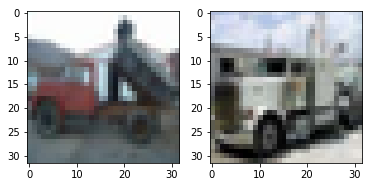

In [28]:
import tensorflow as tf
from matplotlib import pyplot as plt #this is how we display images
%matplotlib inline

print('Test data shape', image.shape)
_,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image[0]) #example 1
ax2.imshow(image[7]) #example 2

In [19]:
label_val[0] #actual correct answer to check how well model is working

<tf.Tensor: id=915613, shape=(), dtype=int64, numpy=9>

In [ ]:
# ___number key____
# airplane: 0
# automobile: 1
# bird: 2
# cat: 3
# deer: 4
# dog: 5
# frog: 6
# horse: 7
# ship: 8
# truck: 9